# Reinforcement Learning Offline

### Phase 0: Import libraries and read data

In [1]:
# import libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import plotly.express as px
import d3rlpy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
from tqdm import tqdm
sns.set_theme()

In [2]:
variables_interes=['pyrite law', 'chalcopyrite law',
       'chalcocite law', 'covelin law', 'crusher index', 'sag power index',
       'ball work index', 'bornite law','charge cell', 'TPH','water', 'speed','HH TPH', 'granulometry','loss of TPH',
       "power","solid percentage","HH charge cell","LL charge cell","delta HH TPH","delta HH charge cell","delta LL charge cell","Edad"]

In [2]:
states=['HH TPH',
 'min_sag power index_10',
 'min_solid percentage_10',
 'min_speed_10',
 'max_granulometry_10',
 'var_speed_10',
 'max_speed_10',
 #'min_delta HH charge cell_10',
 #'max_delta HH charge cell_10',
 'min_HH charge cell_5',
 'var_sag power index_3',
 'Edad',
 'var_solid percentage_10',
 #'var_charge cell_10',
 'var_sag power index_5',
 #'var_charge cell_3',
 'var_solid percentage_3',
 'var_granulometry_3',
 'var_solid percentage_5',
 'var_sag power index_10',
 #'var_charge cell_5',
 'var_granulometry_10',
 'var_speed_3']

actions=[
    'HH charge cell'
    ]

reward=[
    "loss of TPH"
    ]

In [3]:
df_fe = pd.read_csv("../../data/processed data/feature_engineering_08September2023.csv",parse_dates=['Timestamp'], index_col='Timestamp')
df_fe["Edad"]=df_fe["Edad"].astype("category")
# reward
df_fe["loss of TPH"]=df_fe["delta HH TPH"].apply(lambda x: -1 if x>100 else 1)
df_fe.head(1)

,granulometry,charge cell,speed,solid percentage,water,TPH,HH TPH,LL charge cell,HH charge cell,loss of TPH,...,sag power index_(t-1),sag power index_(t-2),sag power index_(t-3),sag power index_(t-4),sag power index_(t-5),Edad_(t-1),Edad_(t-2),Edad_(t-3),Edad_(t-4),Edad_(t-5)
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:03:00,62.811786,858.914758,9.062208,65.085609,2089.536865,3894.792946,4350.0,820.0,900.0,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_events = pd.read_csv("../../data/processed data/events_08September2023.csv")
df_events.head(1)

,inicio perdida,fin perdida,inicio evento,fin evento,impacto TPH,variación HH TPH,std HH TPH,Causalidad sistema de control,Causalidad molino vacio,Tipo de evento,Flag,duración evento
0,2018-01-01 00:51:00,2018-01-01 01:30:00,2018-01-01 00:41:00,2018-01-01 01:40:00,6.131858,False,0.0,False,False,Embancamiento,E,39.0


In [5]:
# Consideramos solo eventos de embancamiento para el entrenamiento del agente
df_events_train=df_events[(df_events["Flag"]=="E")]
df_events_train.head(1)

,inicio perdida,fin perdida,inicio evento,fin evento,impacto TPH,variación HH TPH,std HH TPH,Causalidad sistema de control,Causalidad molino vacio,Tipo de evento,Flag,duración evento
0,2018-01-01 00:51:00,2018-01-01 01:30:00,2018-01-01 00:41:00,2018-01-01 01:40:00,6.131858,False,0.0,False,False,Embancamiento,E,39.0


In [6]:
df_fe.reset_index(inplace=True)

In [7]:
df_full=pd.DataFrame()
# Concat perdidas de interes
for row in tqdm(df_events_train.iterrows(),desc="Progreso iteración escenarios de embancamiento"):

    df_range=df_fe[df_fe["Timestamp"].between(row[1]["inicio evento"],row[1]["fin evento"])]

    df_range["terminals"]=0
    df_range["terminals"].iloc[-1]=1

    df_full=pd.concat([df_full,df_range])   

Progreso iteración escenarios de embancamiento: 35it [00:01, 22.75it/s]

Progreso iteración escenarios de embancamiento: 5557it [40:19,  2.30it/s]


In [8]:
df_fe["terminals"]=0

In [16]:
# Concat estados de no perdida
df_full=pd.concat([df_full,df_fe[df_fe["loss of TPH"]==1]])

In [17]:
# Considerar si eventualmente se concatenan eventos de no perdida, muy probablemente se solapen eventos
df_full.duplicated().sum()
df_full=df_full.drop_duplicates()

In [18]:
df_full.sort_values(by="Timestamp",inplace=True)

In [19]:
df_full.to_csv("../../data/processed data/feature_engineering_event_to_train_26September2023.csv")

In [4]:
df=pd.read_csv("../../data/processed data/feature_engineering_event_to_train_24September2023.csv",parse_dates=['Timestamp'], index_col='Timestamp').drop(["Unnamed: 0"],axis=1)
df.head(1)

,granulometry,charge cell,speed,solid percentage,water,TPH,HH TPH,LL charge cell,HH charge cell,loss of TPH,...,sag power index_(t-2),sag power index_(t-3),sag power index_(t-4),sag power index_(t-5),Edad_(t-1),Edad_(t-2),Edad_(t-3),Edad_(t-4),Edad_(t-5),terminals
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:41:00,62.194272,879.743593,9.250324,72.353758,1682.915344,4352.8471,4350.0,820.0,900.0,1,...,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,0


In [5]:
df.shape

(277288, 290)

In [6]:
df["loss of TPH"].value_counts()

-1    156045
 1    121243
Name: loss of TPH, dtype: int64

### Phase 1: Split data train/test & processing

In [7]:
# Entrenamiento
entrenamiento=pd.concat([df["2020-01":"2020-03"],df["2020-05":"2020-12"],df["2021-01":"2021-08"],df["2021-10":"2021-12"]])
entrenamiento=entrenamiento[entrenamiento["HH charge cell"]<950]
Ytrain=entrenamiento[["loss of TPH","terminals"]]
Xtrain=entrenamiento.drop(columns=["loss of TPH","terminals"])
print(Ytrain["loss of TPH"].value_counts())
print(Ytrain["terminals"].value_counts())
Xtrain.head()

-1    43463
 1    34064
Name: loss of TPH, dtype: int64
0    76067
1     1460
Name: terminals, dtype: int64


,granulometry,charge cell,speed,solid percentage,water,TPH,HH TPH,LL charge cell,HH charge cell,start loss of TPH,...,sag power index_(t-1),sag power index_(t-2),sag power index_(t-3),sag power index_(t-4),sag power index_(t-5),Edad_(t-1),Edad_(t-2),Edad_(t-3),Edad_(t-4),Edad_(t-5)
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-09 14:22:00,38.442361,846.685905,9.312184,67.781064,1951.832156,4106.742419,4100.0,790.0,870.0,0,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0
2020-01-09 14:23:00,38.460617,842.296852,9.311557,67.875273,1955.698954,4136.553286,4100.0,790.0,870.0,0,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0
2020-01-09 14:24:00,38.420183,838.129304,9.313310,67.578678,1928.000205,4021.548683,4100.0,790.0,870.0,0,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0
2020-01-09 14:25:00,38.316664,834.689811,9.311375,67.868407,1922.174629,4070.908574,4100.0,790.0,870.0,0,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0
2020-01-09 14:26:00,38.217893,833.986104,9.250037,68.250478,1877.314003,4043.418297,4100.0,790.0,870.0,0,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0


In [8]:
# Test
test=pd.concat([df["2020-04"],df["2021-09"]])
Ytest=test[["loss of TPH","terminals"]]
Xtest=test.drop(columns=["loss of TPH","terminals"])
print(Ytest["loss of TPH"].value_counts())
print(Ytest["terminals"].value_counts())
Xtest.head()

-1    7195
 1    3616
Name: loss of TPH, dtype: int64
0    10656
1      155
Name: terminals, dtype: int64


,granulometry,charge cell,speed,solid percentage,water,TPH,HH TPH,LL charge cell,HH charge cell,start loss of TPH,...,sag power index_(t-1),sag power index_(t-2),sag power index_(t-3),sag power index_(t-4),sag power index_(t-5),Edad_(t-1),Edad_(t-2),Edad_(t-3),Edad_(t-4),Edad_(t-5)
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-04-01 00:46:00,29.751123,791.153357,9.249962,65.329404,2241.905138,4224.924292,3800.0,760.0,840.0,0,...,116.3165,116.3165,116.3165,116.3165,116.3165,2.0,2.0,2.0,2.0,2.0
2020-04-01 00:47:00,29.784485,795.044488,9.250016,65.191381,2234.367939,4189.887778,3800.0,760.0,840.0,0,...,116.3165,116.3165,116.3165,116.3165,116.3165,2.0,2.0,2.0,2.0,2.0
2020-04-01 00:48:00,29.818777,800.887190,9.248461,65.265251,2223.684998,4177.505890,3800.0,760.0,840.0,0,...,116.3165,116.3165,116.3165,116.3165,116.3165,2.0,2.0,2.0,2.0,2.0
2020-04-01 00:49:00,29.814648,804.353308,9.250633,65.145120,2218.153436,4148.998990,3800.0,760.0,840.0,0,...,116.3165,116.3165,116.3165,116.3165,116.3165,2.0,2.0,2.0,2.0,2.0
2020-04-01 00:50:00,29.779540,809.189376,9.249675,65.246991,2212.167336,4152.443429,3800.0,760.0,840.0,0,...,116.3165,116.3165,116.3165,116.3165,116.3165,2.0,2.0,2.0,2.0,2.0


In [9]:
# scaler
scaler = MinMaxScaler()

In [10]:
Xtrain_0=pd.DataFrame(scaler.fit_transform(Xtrain[states+actions]),columns=states+actions,index=Xtrain.index)
Xtrain_0.head()

,HH TPH,min_sag power index_10,min_solid percentage_10,min_speed_10,max_granulometry_10,var_speed_10,max_speed_10,min_HH charge cell_5,var_sag power index_3,Edad,var_solid percentage_10,var_sag power index_5,var_solid percentage_3,var_granulometry_3,var_solid percentage_5,var_sag power index_10,var_granulometry_10,var_speed_3,HH charge cell
Timestamp,,,,,,,,,,,,,,,,,,,
2020-01-09 14:22:00,0.633333,NaN,0.344404,0.988517,0.214562,3.203434e-05,0.994790,0.716981,NaN,0.5,0.003368,NaN,0.001740,0.000052,0.002707,NaN,0.000169,1.874711e-08,0.716981
2020-01-09 14:23:00,0.633333,NaN,0.344404,0.990652,0.214502,1.175451e-05,0.994790,0.716981,NaN,0.5,0.004414,NaN,0.000600,0.000010,0.002252,NaN,0.000168,3.480607e-08,0.716981
2020-01-09 14:24:00,0.633333,NaN,0.332329,0.995574,0.214502,1.891877e-08,0.994795,0.716981,NaN,0.5,0.006094,NaN,0.000361,0.000002,0.001910,NaN,0.000193,3.638075e-08,0.716981
2020-01-09 14:25:00,0.633333,NaN,0.332329,0.995553,0.214502,2.436918e-08,0.994795,0.716981,NaN,0.5,0.005694,NaN,0.000450,0.000025,0.000722,NaN,0.000191,5.264279e-08,0.716981
2020-01-09 14:26:00,0.633333,NaN,0.332329,0.988476,0.214502,2.422431e-05,0.994795,0.716981,NaN,0.5,0.004741,NaN,0.001783,0.000046,0.000990,NaN,0.000163,5.970853e-05,0.716981


In [11]:
Xtest_0=pd.DataFrame(scaler.transform(Xtest[states+actions]),columns=states+actions,index=Xtest.index)
Xtest_0.head()

,HH TPH,min_sag power index_10,min_solid percentage_10,min_speed_10,max_granulometry_10,var_speed_10,max_speed_10,min_HH charge cell_5,var_sag power index_3,Edad,var_solid percentage_10,var_sag power index_5,var_solid percentage_3,var_granulometry_3,var_solid percentage_5,var_sag power index_10,var_granulometry_10,var_speed_3,HH charge cell
Timestamp,,,,,,,,,,,,,,,,,,,
2020-04-01 00:46:00,0.433333,0.507346,0.187816,0.988374,0.106462,2.604991e-08,0.98753,0.603774,0.0,1.0,0.000058,3.492077e-31,0.000012,3.301829e-07,0.000009,3.352394e-31,0.000277,3.660610e-08,0.603774
2020-04-01 00:47:00,0.433333,0.507346,0.187816,0.988374,0.103807,2.395699e-08,0.98753,0.603774,0.0,1.0,0.000071,3.492077e-31,0.000076,2.939491e-06,0.000046,3.352394e-31,0.000143,4.633859e-09,0.603774
2020-04-01 00:48:00,0.433333,0.507346,0.187816,0.988294,0.101822,3.536029e-08,0.98753,0.603774,0.0,1.0,0.000058,3.492077e-31,0.000075,5.102594e-06,0.000046,3.352394e-31,0.000061,3.589372e-08,0.603774
2020-04-01 00:49:00,0.433333,0.507346,0.187144,0.988294,0.099010,4.048815e-08,0.98753,0.603774,0.0,1.0,0.000063,3.492077e-31,0.000058,1.562702e-06,0.000088,3.352394e-31,0.000013,5.774300e-08,0.603774
2020-04-01 00:50:00,0.433333,0.507346,0.187144,0.988294,0.097374,3.748037e-08,0.98753,0.603774,0.0,1.0,0.000058,3.492077e-31,0.000066,2.072806e-06,0.000083,3.352394e-31,0.000003,5.461748e-08,0.603774


In [21]:
df_mdp_train=pd.DataFrame()
# Desfase de x minutos para considerar el estado del molino 5 minutos antes de tomar la decisión
desfase=5
df_mdp_train[states]=Xtrain_0[states].shift(desfase)
df_mdp_train["HH charge cell"]=Xtrain_0[actions]
df_mdp_train[["loss of TPH","terminals"]]=Ytrain[["loss of TPH","terminals"]]
df_mdp_train.dropna(inplace=True)
print(df_mdp_train.shape)
df_mdp_train.head()

(72723, 21)


,HH TPH,min_sag power index_10,min_solid percentage_10,min_speed_10,max_granulometry_10,var_speed_10,max_speed_10,min_HH charge cell_5,var_sag power index_3,Edad,...,var_sag power index_5,var_solid percentage_3,var_granulometry_3,var_solid percentage_5,var_sag power index_10,var_granulometry_10,var_speed_3,HH charge cell,loss of TPH,terminals
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-10 02:00:00,0.633333,0.376139,0.660121,0.988408,0.309544,7.849965e-09,0.987454,0.641509,0.0,0.5,...,0.0,0.000012,5.598841e-05,0.000021,3.352394e-31,0.000039,1.587724e-09,0.641509,1,0
2020-01-10 02:01:00,0.633333,0.376139,0.677867,0.988408,0.309544,8.367865e-09,0.987454,0.641509,0.0,0.5,...,0.0,0.000014,6.684334e-05,0.000011,3.352394e-31,0.000081,1.034646e-08,0.641509,1,0
2020-01-10 02:02:00,0.633333,0.376139,0.683744,0.988408,0.309544,6.684879e-09,0.987454,0.641509,0.0,0.5,...,0.0,0.000013,1.677810e-05,0.000012,3.352394e-31,0.000113,3.766483e-09,0.641509,1,0
2020-01-10 02:03:00,0.633333,0.376139,0.686815,0.988408,0.309544,7.087327e-09,0.987454,0.641509,0.0,0.5,...,0.0,0.000041,8.783539e-07,0.000030,3.352394e-31,0.000128,8.913306e-09,0.641509,1,0
2020-01-10 02:04:00,0.633333,0.376139,0.696914,0.988408,0.309544,7.139580e-09,0.987454,0.641509,0.0,0.5,...,0.0,0.000074,7.432162e-06,0.000057,3.352394e-31,0.000118,3.565713e-09,0.641509,1,0


In [23]:
observations_train=df_mdp_train[states].to_numpy()
actions_train=df_mdp_train["HH charge cell"].to_numpy().reshape(-1,1)
rewards_train=df_mdp_train[reward].to_numpy().squeeze()
terminals_train=df_mdp_train["terminals"].to_numpy()

dataset_train = d3rlpy.dataset.MDPDataset(
    observations=observations_train,
    actions=actions_train,
    rewards=rewards_train,
    terminals=terminals_train,
)

In [30]:
df_mdp_test=pd.DataFrame()
df_mdp_test[states]=Xtest_0[states]
df_mdp_test["HH charge cell"]=Xtest_0[actions]
df_mdp_test.dropna(inplace=True)
print(df_mdp_test.shape)
df_mdp_test.head()

(10303, 19)


,HH TPH,min_sag power index_10,min_solid percentage_10,min_speed_10,max_granulometry_10,var_speed_10,max_speed_10,min_HH charge cell_5,var_sag power index_3,Edad,var_solid percentage_10,var_sag power index_5,var_solid percentage_3,var_granulometry_3,var_solid percentage_5,var_sag power index_10,var_granulometry_10,var_speed_3,HH charge cell
Timestamp,,,,,,,,,,,,,,,,,,,
2020-04-01 00:46:00,0.433333,0.507346,0.187816,0.988374,0.106462,2.604991e-08,0.98753,0.603774,0.0,1.0,0.000058,3.492077e-31,0.000012,3.301829e-07,0.000009,3.352394e-31,0.000277,3.660610e-08,0.603774
2020-04-01 00:47:00,0.433333,0.507346,0.187816,0.988374,0.103807,2.395699e-08,0.98753,0.603774,0.0,1.0,0.000071,3.492077e-31,0.000076,2.939491e-06,0.000046,3.352394e-31,0.000143,4.633859e-09,0.603774
2020-04-01 00:48:00,0.433333,0.507346,0.187816,0.988294,0.101822,3.536029e-08,0.98753,0.603774,0.0,1.0,0.000058,3.492077e-31,0.000075,5.102594e-06,0.000046,3.352394e-31,0.000061,3.589372e-08,0.603774
2020-04-01 00:49:00,0.433333,0.507346,0.187144,0.988294,0.099010,4.048815e-08,0.98753,0.603774,0.0,1.0,0.000063,3.492077e-31,0.000058,1.562702e-06,0.000088,3.352394e-31,0.000013,5.774300e-08,0.603774
2020-04-01 00:50:00,0.433333,0.507346,0.187144,0.988294,0.097374,3.748037e-08,0.98753,0.603774,0.0,1.0,0.000058,3.492077e-31,0.000066,2.072806e-06,0.000083,3.352394e-31,0.000003,5.461748e-08,0.603774


### Phase 2: Model train

In [25]:
# episode-wise split
train_episodes, test_episodes = train_test_split(dataset_train.episodes)

# setup metrics
metrics = {
  "soft_opc": d3rlpy.metrics.scorer.soft_opc_scorer(return_threshold=180),
  "initial_value": d3rlpy.metrics.scorer.initial_state_value_estimation_scorer,
}

awac = d3rlpy.algos.AWAC()

# start training with episode-wise splits
data_train=awac.fit(
    train_episodes,
    n_epochs=10,
    scorers=metrics,
    eval_episodes=test_episodes,
)

2023-09-25 23:55.57 [debug    ] RoundIterator is selected.
2023-09-25 23:55.57 [info     ] Directory is created at d3rlpy_logs\AWAC_20230925235557
2023-09-25 23:55.57 [debug    ] Building models...
2023-09-25 23:55.57 [debug    ] Models have been built.
2023-09-25 23:55.57 [info     ] Parameters are saved to d3rlpy_logs\AWAC_20230925235557\params.json params={'action_scaler': None, 'actor_encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False}, 'batch_size': 1024, 'critic_encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'critic_learning_rate': 0.0003, 'critic_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'gamma': 0.99, 'generated_maxle

Epoch 1/10: 100%|██████████| 53/53 [00:05<00:00,  9.91it/s, critic_loss=1.94, actor_loss=56.4, mean_std=0.0502]


2023-09-25 23:56.04 [info     ] AWAC_20230925235557: epoch=1 step=53 epoch=1 metrics={'time_sample_batch': 0.003029616373889851, 'time_algorithm_update': 0.09718994824391491, 'critic_loss': 1.94135160940998, 'actor_loss': 55.69799487995652, 'mean_std': 0.050246847758315644, 'time_step': 0.10055205057252128, 'soft_opc': nan, 'initial_value': -0.2477668821811676} step=53
2023-09-25 23:56.04 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230925235557\model_53.pt


Epoch 2/10: 100%|██████████| 53/53 [00:05<00:00, 10.19it/s, critic_loss=1.92, actor_loss=34.4, mean_std=0.051] 


2023-09-25 23:56.11 [info     ] AWAC_20230925235557: epoch=2 step=106 epoch=2 metrics={'time_sample_batch': 0.002348769385859651, 'time_algorithm_update': 0.09503661461596219, 'critic_loss': 1.921648846482331, 'actor_loss': 34.36147099620891, 'mean_std': 0.05102109149941858, 'time_step': 0.09744197467588028, 'soft_opc': nan, 'initial_value': -0.2864045798778534} step=106
2023-09-25 23:56.11 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230925235557\model_106.pt


Epoch 3/10: 100%|██████████| 53/53 [00:05<00:00, 10.38it/s, critic_loss=1.91, actor_loss=31.6, mean_std=0.0518]


2023-09-25 23:56.17 [info     ] AWAC_20230925235557: epoch=3 step=159 epoch=3 metrics={'time_sample_batch': 0.002342592995121794, 'time_algorithm_update': 0.09321445788977281, 'critic_loss': 1.9112448984721921, 'actor_loss': 31.511940326330798, 'mean_std': 0.051824106008939025, 'time_step': 0.09599349183856316, 'soft_opc': nan, 'initial_value': -0.30416643619537354} step=159
2023-09-25 23:56.17 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230925235557\model_159.pt


Epoch 4/10: 100%|██████████| 53/53 [00:05<00:00, 10.10it/s, critic_loss=1.9, actor_loss=29.9, mean_std=0.0527] 


2023-09-25 23:56.23 [info     ] AWAC_20230925235557: epoch=4 step=212 epoch=4 metrics={'time_sample_batch': 0.0005133871762257702, 'time_algorithm_update': 0.09740506028229336, 'critic_loss': 1.8995722419810745, 'actor_loss': 29.835037807248675, 'mean_std': 0.052687700064677115, 'time_step': 0.09791844745851913, 'soft_opc': nan, 'initial_value': -0.3046950697898865} step=212
2023-09-25 23:56.23 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230925235557\model_212.pt


Epoch 5/10: 100%|██████████| 53/53 [00:04<00:00, 10.66it/s, critic_loss=1.9, actor_loss=28.6, mean_std=0.0536] 


2023-09-25 23:56.29 [info     ] AWAC_20230925235557: epoch=5 step=265 epoch=5 metrics={'time_sample_batch': 0.001966062581764077, 'time_algorithm_update': 0.09147725465162745, 'critic_loss': 1.8949137003916614, 'actor_loss': 28.67778925625783, 'mean_std': 0.053602341913952016, 'time_step': 0.09349990790744997, 'soft_opc': nan, 'initial_value': -0.41179975867271423} step=265
2023-09-25 23:56.29 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230925235557\model_265.pt


Epoch 6/10: 100%|██████████| 53/53 [00:05<00:00, 10.27it/s, critic_loss=1.89, actor_loss=27.8, mean_std=0.0545]


2023-09-25 23:56.35 [info     ] AWAC_20230925235557: epoch=6 step=318 epoch=6 metrics={'time_sample_batch': 0.002128956452855524, 'time_algorithm_update': 0.09358286407758605, 'critic_loss': 1.8903887046957917, 'actor_loss': 27.67122592566148, 'mean_std': 0.054550392307200525, 'time_step': 0.0960066093588775, 'soft_opc': nan, 'initial_value': -0.4128442108631134} step=318
2023-09-25 23:56.35 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230925235557\model_318.pt


Epoch 7/10: 100%|██████████| 53/53 [00:05<00:00, 10.22it/s, critic_loss=1.88, actor_loss=26.6, mean_std=0.0555]


2023-09-25 23:56.42 [info     ] AWAC_20230925235557: epoch=7 step=371 epoch=7 metrics={'time_sample_batch': 0.0035212894655623525, 'time_algorithm_update': 0.09417092125370817, 'critic_loss': 1.8845807718780805, 'actor_loss': 26.56082376444115, 'mean_std': 0.05552697884586622, 'time_step': 0.09769221071927052, 'soft_opc': nan, 'initial_value': -0.4113406538963318} step=371
2023-09-25 23:56.42 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230925235557\model_371.pt


Epoch 8/10: 100%|██████████| 53/53 [00:05<00:00, 10.24it/s, critic_loss=1.88, actor_loss=25.5, mean_std=0.0565]


2023-09-25 23:56.48 [info     ] AWAC_20230925235557: epoch=8 step=424 epoch=8 metrics={'time_sample_batch': 0.002758197064669627, 'time_algorithm_update': 0.09448538186415187, 'critic_loss': 1.8749419495744526, 'actor_loss': 25.477157412834888, 'mean_std': 0.05652021012216244, 'time_step': 0.09753833176954738, 'soft_opc': nan, 'initial_value': -0.49839627742767334} step=424
2023-09-25 23:56.48 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230925235557\model_424.pt


Epoch 9/10: 100%|██████████| 53/53 [00:04<00:00, 10.62it/s, critic_loss=1.87, actor_loss=24.5, mean_std=0.0575]


2023-09-25 23:56.54 [info     ] AWAC_20230925235557: epoch=9 step=477 epoch=9 metrics={'time_sample_batch': 0.002695740393872531, 'time_algorithm_update': 0.0906238780831391, 'critic_loss': 1.8701896172649455, 'actor_loss': 24.511168138036187, 'mean_std': 0.05753109006668037, 'time_step': 0.09333848503400695, 'soft_opc': nan, 'initial_value': -0.5399142503738403} step=477
2023-09-25 23:56.54 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230925235557\model_477.pt


Epoch 10/10: 100%|██████████| 53/53 [00:05<00:00,  9.84it/s, critic_loss=1.87, actor_loss=23.5, mean_std=0.0585]


2023-09-25 23:57.01 [info     ] AWAC_20230925235557: epoch=10 step=530 epoch=10 metrics={'time_sample_batch': 0.002893848239250903, 'time_algorithm_update': 0.09768397853059589, 'critic_loss': 1.8741141872585945, 'actor_loss': 23.48303852441176, 'mean_std': 0.05855628166277454, 'time_step': 0.10092835606269117, 'soft_opc': nan, 'initial_value': -0.5656801462173462} step=530
2023-09-25 23:57.01 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230925235557\model_530.pt


In [15]:
# save full parameters only
awac.save_model('../models/awac.pt')


In [16]:
# load full parameters with manual setup
awac =d3rlpy.algos.AWAC()
awac.build_with_dataset(dataset_train)
awac.load_model('../models/awac.pt')

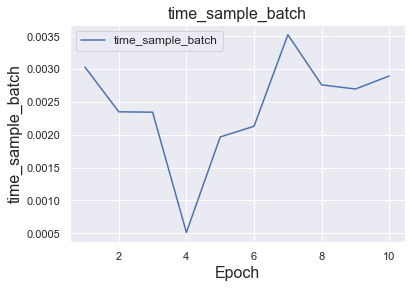

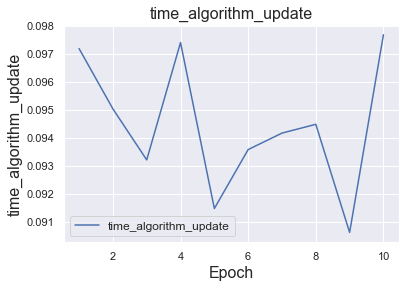

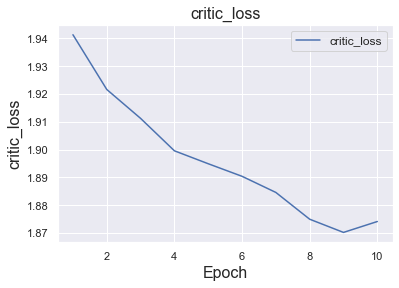

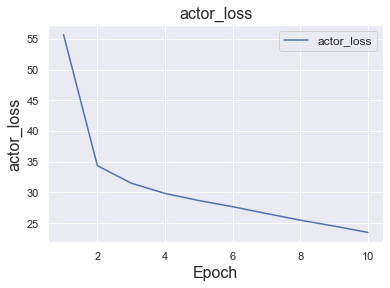

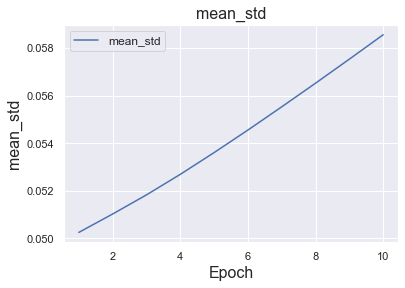

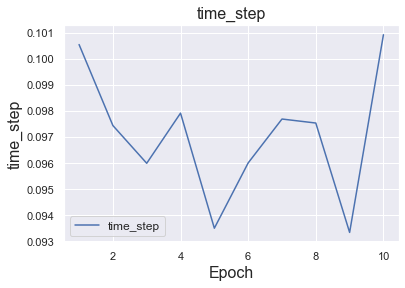

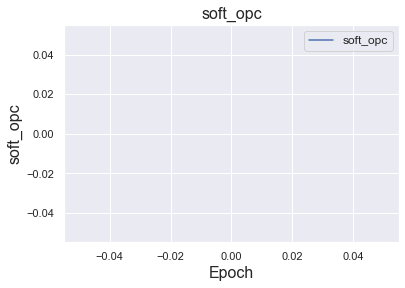

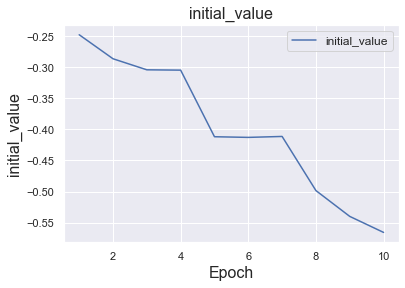

In [26]:
# Métricas que queremos graficar
metrics_to_plot = list(data_train[0][1].keys())

# Crear un gráfico de líneas para cada métr
for metric in metrics_to_plot:
    x = [entry[0] for entry in data_train]
    y = [entry[1][metric] for entry in data_train]
    plt.plot(x, y, label=metric)

    # Etiquetas y título del gráfico
    plt.title(f'{metric}', fontsize=16)

    # Agrandar el tamaño de fuente de la leyenda
    plt.legend(fontsize=12)

    # Etiquetas y título del gráfico
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel(metric, fontsize=16)

    # Mostrar el gráfico
    plt.show()

### Phase 3: Model evaluation

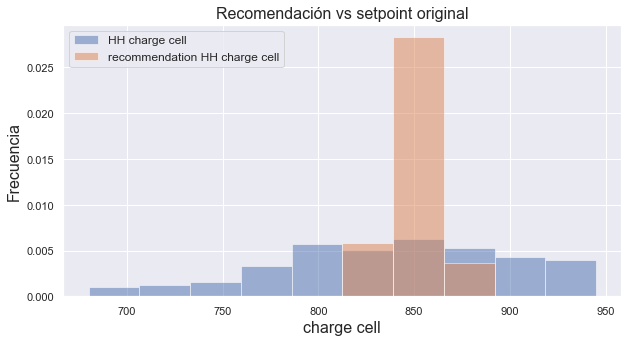

,HH charge cell,recommendation HH charge cell
count,72723.0,72723.0
mean,838.0,850.0
std,60.0,11.0
min,680.0,817.0
25%,800.0,842.0
50%,840.0,850.0
75%,890.0,857.0
max,945.0,881.0


In [27]:
#  rec HH charge cell data train
df_fin=df_mdp_train[states+actions].copy()

original_hh_charge_cell=pd.DataFrame(scaler.inverse_transform(df_fin[states+actions]),columns=states+actions,index=df_fin.index)["HH charge cell"].values

df_fin["HH charge cell"]=awac.predict([observations_train]).squeeze()

df_fin=pd.DataFrame(scaler.inverse_transform(df_fin),columns=df_fin.columns,index=df_fin.index).rename(columns={"HH charge cell":
                                                                                                       "recommendation HH charge cell"})

df_fin["HH charge cell"]=original_hh_charge_cell
ax=df_fin[["HH charge cell","recommendation HH charge cell"]].plot(kind="hist",figsize=(10,5),density=True,alpha=0.5)
ax.set_title("Recomendación vs setpoint original",fontsize=16)
ax.set_xlabel('charge cell', fontsize=16)
ax.set_ylabel('Frecuencia', fontsize=16)
ax.legend(fontsize=12)
plt.show()
df_fin[["HH charge cell","recommendation HH charge cell"]].describe().round(0)

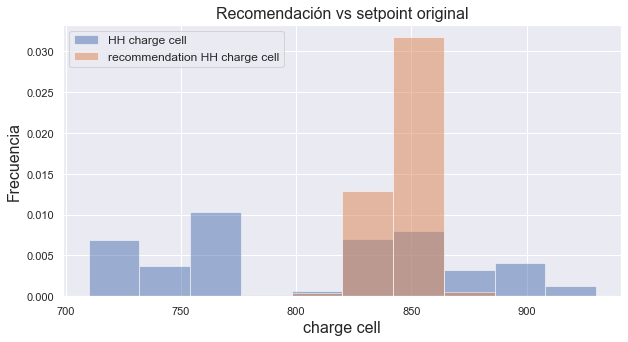

,HH charge cell,recommendation HH charge cell
count,10303.0,10303.0
mean,808.0,845.0
std,60.0,10.0
min,710.0,819.0
25%,760.0,840.0
50%,830.0,847.0
75%,860.0,851.0
max,930.0,870.0


In [31]:
#  rec HH charge cell data test
df_fin=df_mdp_test[states+actions].copy()

original_hh_charge_cell=pd.DataFrame(scaler.inverse_transform(df_fin[states+actions]),columns=states+actions,index=df_fin.index)["HH charge cell"].values

observations_test=df_fin[states].to_numpy()

df_fin["HH charge cell"]=awac.predict([observations_test]).squeeze()

df_fin=pd.DataFrame(scaler.inverse_transform(df_fin),columns=df_fin.columns,index=df_fin.index).rename(columns={"HH charge cell":
                                                                                                       "recommendation HH charge cell"})

df_fin["HH charge cell"]=original_hh_charge_cell
ax=df_fin[["HH charge cell","recommendation HH charge cell"]].plot(kind="hist",figsize=(10,5),density=True,alpha=0.5)
ax.set_title("Recomendación vs setpoint original",fontsize=16)
ax.set_xlabel('charge cell', fontsize=16)
ax.set_ylabel('Frecuencia', fontsize=16)
ax.legend(fontsize=12)
plt.show()
df_fin[["HH charge cell","recommendation HH charge cell"]].describe().round(0)

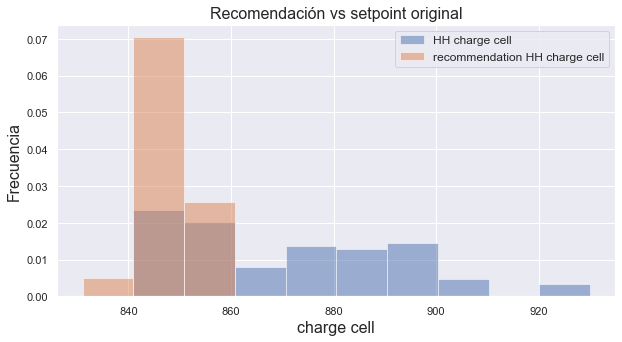

,HH charge cell,recommendation HH charge cell
count,3419.0,3419.0
mean,875.0,848.0
std,22.0,5.0
min,840.0,831.0
25%,860.0,846.0
50%,870.0,848.0
75%,890.0,851.0
max,930.0,860.0


In [38]:
# Test
test=df_mdp_test["2021-09"].copy()
original_hh_charge_cell=pd.DataFrame(scaler.inverse_transform(test[states+actions]),columns=states+actions,index=test.index)["HH charge cell"].values

observations_test=test[states].to_numpy()

test["HH charge cell"]=awac.predict([observations_test]).squeeze()

# Recomendación futura
test["HH charge cell"]=test["HH charge cell"].shift(-desfase)

df_fin=pd.DataFrame(scaler.inverse_transform(test[states+actions]),columns=states+actions,index=test.index).rename(columns={"HH charge cell":
                                                                                                       "recommendation HH charge cell"})
 
                                                                                                       
df_fin["HH charge cell"]=original_hh_charge_cell
df_fin=df_fin.join(df[["TPH","charge cell"]])
df_fin.dropna(inplace=True)

ax=df_fin[["HH charge cell","recommendation HH charge cell"]].plot(kind="hist",alpha=0.5,figsize=(10,5),density=True,)
ax.set_title("Recomendación vs setpoint original",fontsize=16)
ax.set_xlabel('charge cell', fontsize=16)
ax.set_ylabel('Frecuencia', fontsize=16)
ax.legend(fontsize=12)
plt.show()
df_fin[["HH charge cell","recommendation HH charge cell"]].describe().round(0)

In [39]:
titulos=tuple(["TPH & HH TPH", "Real charge cell setpoint & Recommendation charge cell setpoint",#"Real charge cell setpoint","Recommendation charge cell setpoint",
               ])
fig = make_subplots(
    rows=4, cols=1,
    subplot_titles=titulos,
     shared_xaxes=True, 
     vertical_spacing=0.05
    )

fig.add_trace(go.Scatter(x=df_fin.index, y=df_fin['TPH'], ##FF6511
                    mode='lines',
                    name="TPH",line=dict(width=3, ),legendgroup = '1'),row=1, col=1)  

fig.add_trace(go.Scatter(x=df_fin.index, y=df_fin['HH TPH'], ##FF6511
                    mode='lines',
                    name="HH TPH",line=dict(width=3, ),legendgroup = '1'),row=1, col=1)  






#############
fig.add_trace(go.Scatter(x=df_fin.index, y=df_fin['recommendation HH charge cell'], 
                    mode='lines',
                    name="recommendation HH charge cell",line=dict(width=3, ),legendgroup = '1'),row=2, col=1) 

fig.add_trace(go.Scatter(x=df_fin.index, y=df_fin['HH charge cell'], 
                    mode='lines',
                    name="HH charge cell",line=dict(width=3, ),legendgroup = '1',),row=2, col=1) 

fig.add_trace(go.Scatter(x=df_fin.index, y=df_fin['charge cell'], 
                    mode='lines',
                    name="charge cell",line=dict(width=3, ),legendgroup = '1'),row=2, col=1) 



###############




#################
fig.add_trace(go.Scatter(x=df_fin.index, y=df_fin['charge cell'], 
                    mode='lines',
                    name="charge cell",line=dict(width=3, ),legendgroup = '1'),row=3, col=1)  




fig.add_trace(go.Scatter(x=df_fin.index, y=df_fin['HH charge cell'], 
                    mode='lines',
                    name="HH charge cell",line=dict(width=1, ),legendgroup = '1',showlegend=False),row=3, col=1) 

fig.add_trace(go.Scatter(x=df_fin.index, y=df_fin['HH charge cell']-80, 
                    mode='lines',
                    name="LL charge cell",line=dict(width=1, ),legendgroup = '1',fill='tonexty',showlegend=False),row=3, col=1)   

#################

######
fig.add_trace(go.Scatter(x=df_fin.index, y=df_fin['recommendation HH charge cell'], 
                    mode='lines',
                    name="recommendation HH charge cell",line=dict(width=1, ),legendgroup = '1',showlegend=False),row=4, col=1) 

fig.add_trace(go.Scatter(x=df_fin.index, y=df_fin['recommendation HH charge cell']-80, 
                    mode='lines',
                    name="recommendation LL charge cell",line=dict(width=1, ),legendgroup = '1',fill='tonexty',showlegend=False),row=4, col=1) 
##############
fig.add_trace(go.Scatter(x=df_fin.index, y=df_fin['charge cell'], 
                    mode='lines',
                    name="charge cell",line=dict(width=3, ),legendgroup = '1'),row=4, col=1)  


fig.update_layout(height=700, width=1200, title_text="Temporal signal analysis")
fig.update_layout(hovermode="x unified")

fig.show()